In [1]:
import copy
from collections import defaultdict
import itertools
import json
import math

import matplotlib.pyplot as plt
import numpy as np
import openml
import pathlib
import pandas as pd
from pandas.plotting import scatter_matrix
import yaml
import scipy.stats
from plot_utils.style import style_dc

In [2]:
# rsync -a --exclude '*.sif' --exclude venv /run/user/10328/gvfs/sftp:host=aadlogin.informatik.uni-freiburg.de/mhome/eggenspk/AUTOML_BENCHMARK/ /home/feurerm/projects/automlbenchmark/
# rsync -a --exclude '*.sif' --exclude venv feurerm@aadlogin.informatik.uni-freiburg.de:/mhome/eggenspk/AUTOML_BENCHMARK/autosklearn/ /home/feurerm/projects/automlbenchmark/autosklearn/

import getpass
username = getpass.getuser()
fl = {
    'eggenspk': "/run/user/10327/gvfs/sftp:host=aadlogin.informatik.uni-freiburg.de/home/eggenspk/metahome/AUTOML_BENCHMARK/",
    'feurerm': "/home/feurerm/projects/2021_posh_automlbenchmark"
}[username]

fl = pathlib.Path(fl)

In [3]:
datasets = (
    'Airlines', 'Albert', 'Covertype', 'Dionis', 'adult', 'Amazon_employee_access',
    'APSFailure', 'bank-marketing', 'connect-4', 'Fashion-MNIST', 'guillermo',
    'Helena', 'higgs', 'Jannis', 'jungle_chess_2pcs_raw_endgame_complete', 'KDDCup09_appetency',
    'MiniBooNE', 'nomao', 'numerai28.6', 'riccardo', 'Robert', 'Shuttle', 'Volkert',
    'Australian', 'blood-transfusion', 'car', 'christine', 'cnae-9', 'credit-g', 'dilbert',
    'fabert', 'jasmine', 'kc1', 'kr-vs-kp', 'mfeat-factors', 'phoneme', 'segment', 'sylvine', 'vehicle'
)

In [4]:
to_load = (
    ('v3.32.1.4', 'H2O/2021.07.19-23.30.15'),
    ('v3.32.1.4', 'H2O/2021.07.21-22.19.10'),
    ('v3.32.1.4', 'H2O/2021.07.22-08.53.54'),
    ('v3.32.1.4', 'H2O/2021.07.27-21.29.00'),
    ('v3.32.1.4', 'H2O/2021.08.18-14.12.30'),
    ('v0.11.7', 'TPOT/2021.07.19-21.11.11'),
    ('v0.11.7', 'TPOT/2021.07.22-14.05.42'),
    ('v0.11.7', 'TPOT/2021.07.22-22.17.28'),
    ('v0.11.7', 'TPOT/2021.07.27-17.51.02'),
    ('v0.11.7', 'TPOT/2021.08.18-14.01.21'),
    ('sklearn v0.24.2', 'TunedRandomForest/2021.07.20-11.38.49'),
    ('sklearn v0.24.2', 'TunedRandomForest/2021.07.22-18.05.38'),
    ('sklearn v0.24.2', 'TunedRandomForest/2021.07.22-23.55.12'),
    ('sklearn v0.24.2', 'TunedRandomForest/2021.07.27-10.26.48'),
    ('sklearn v0.24.2', 'TunedRandomForest/2021.08.18-14.41.36'),
    ('2.6.3', 'AutoWEKA/2021.07.20-08.56.59'),
    ('2.6.3', 'AutoWEKA/2021.07.22-18.09.50'),
    ('2.6.3', 'AutoWEKA/2021.07.22-23.58.51'),
    ('2.6.3', 'AutoWEKA/2021.07.27-22.20.13'),
    ('2.6.3', 'AutoWEKA/2021.08.18-13.00.44'),
    ('0.12.7', 'autosklearn2/2021.07.21-00.10.04'),
    ('0.12.7', 'autosklearn2/2021.07.21-20.53.21'),
    ('0.12.7', 'autosklearn2/2021.07.21-23.21.55'),
    ('0.12.7', 'autosklearn2/2021.07.31-12.45.57'),
    ('0.12.7', 'autosklearn2/2021.08.18-11.18.52'),
    ('0.12.7', 'autosklearn/2021.07.20-23.36.52'),
    ('0.12.7', 'autosklearn/2021.07.21-22.19.43'),
    ('0.12.7', 'autosklearn/2021.07.22-10.55.21'),
    ('0.12.7', 'autosklearn/2021.07.30-20.39.07'),
    ('0.12.7', 'autosklearn/2021.08.18-11.01.31'),
)

In [5]:
exclude = ["logs", "scripts", "bench"]

res = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
dataset_to_task_id = dict()
for ver, date_dir in to_load:
    date_dir = fl / date_dir
    if not date_dir.is_dir(): continue
    date = date_dir.name

    with open(date_dir / 'constraints.yaml') as fh:
        yamal = yaml.load(fh)
        assert len(yamal) == 1
        constraint_key = list(yamal.keys())[0]


    for dataset_dir in date_dir.iterdir():
        try:
            if not dataset_dir.is_dir(): continue
            if np.sum([e in dataset_dir.name for e in exclude]) > 0: continue

            dir_name = dataset_dir.name
            
            if (dataset_dir / "results.csv").exists():
                pass
            elif (dataset_dir / dir_name).is_dir():
                dataset_dir = dataset_dir / dir_name

            dataset = dir_name.split("_")
            for i in range(len(dataset)):
                if dataset[i] in ["small", "medium", "large"]:

                    if dataset[i + 1] in ("3600s8c32G", "14400s8c32G"):
                        dataset_sizes = dataset[i]
                        method_name = dataset[:i]
                        dataset = dataset[i+2: -1]
                        break

                    else:
                        dataset_sizes = dataset[i]
                        method_name = dataset[:i]
                        dataset = dataset[i+1: -1]
                        break

            dataset = "_".join(dataset)
            if dataset not in datasets:
                continue
            method_name = "_".join(method_name)
            seed = int(float(dir_name.split("_")[-1]))

            out_fl = list(dataset_dir.glob("results.csv"))
            if len(out_fl) != 1:
                continue
            assert len(out_fl) == 1
            result = pd.read_csv(out_fl[0])

            # Some manual corrections
            if dataset == 'numerai28.6':
                assert result.iloc[0]["task"] in ('numerai28.6', 'numerai28_6')
            else:
                assert dataset == result.iloc[0]["task"], (dataset, result)

            task_id = int(result.iloc[0]["id"].split("/")[-1])
            dataset_to_task_id[dataset] = task_id
            fold = result.iloc[0]["fold"]

            try:
                metric = result.iloc[0]["metric"]
            except KeyError:
                try:
                    if np.isfinite(float(result.iloc[0]["auc"])):
                        metric = "auc"
                    else:
                        metric = "logloss"
                except KeyError:
                    if np.isfinite(float(result.iloc[0]["logloss"])):
                        metric = "logloss"
                    else:
                        print(out_fl)
                        print(result)
                        continue

            try:
                if metric == "auc":
                    res[(method_name + ver, date, constraint_key)][dataset][fold] = (1 - result.iloc[0][metric])
                    #res[ver][date][dataset].append(1 - result.iloc[0][metric])
                elif metric == "neg_logloss":
                    res[(method_name + ver, date, constraint_key)][dataset][fold] = (result.iloc[0]['logloss'])
                elif metric == "logloss":
                    res[(method_name + ver, date, constraint_key)][dataset][fold] = (result.iloc[0][metric])
                else:
                    print(out_fl)
                    print(result)
                    continue
            except:
                print(result.iloc[0])
                raise

        except:
            print(dataset_dir)
            raise

<ipython-input-5-3de596568197>:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yamal = yaml.load(fh)


In [6]:
# Dataset to id
datasets = []
for v in res:
    datasets.extend(list(res[v].keys()))
datasets = np.sort(list(set(datasets)))[::-1]
datasets
print(len(datasets))

39


In [7]:
datasets_in_tasks = list(dataset_to_task_id.keys())
for dataset in datasets_in_tasks:
    if dataset not in datasets:
        del dataset_to_task_id[dataset]
print(len(dataset_to_task_id))

39


In [8]:
dataset_to_task_id

{'jungle_chess_2pcs_raw_endgame_complete': 167119,
 'fabert': 168910,
 'blood-transfusion': 10101,
 'vehicle': 53,
 'segment': 146822,
 'Robert': 168332,
 'riccardo': 168338,
 'Shuttle': 146212,
 'car': 146821,
 'connect-4': 146195,
 'kc1': 3917,
 'Volkert': 168331,
 'KDDCup09_appetency': 3945,
 'dilbert': 168909,
 'guillermo': 168337,
 'Australian': 146818,
 'nomao': 9977,
 'Albert': 189356,
 'phoneme': 9952,
 'higgs': 146606,
 'jasmine': 168911,
 'MiniBooNE': 168335,
 'Covertype': 7593,
 'adult': 7592,
 'Fashion-MNIST': 146825,
 'Helena': 168329,
 'christine': 168908,
 'Dionis': 189355,
 'credit-g': 31,
 'cnae-9': 9981,
 'APSFailure': 168868,
 'Amazon_employee_access': 34539,
 'Jannis': 168330,
 'numerai28.6': 167120,
 'kr-vs-kp': 3,
 'bank-marketing': 14965,
 'Airlines': 189354,
 'mfeat-factors': 12,
 'sylvine': 168912}

In [9]:
print(res.keys())

dict_keys([('H2OAutoMLv3.32.1.4', '2021.07.19-23.30.15', '3600s8c32G'), ('H2OAutoMLv3.32.1.4', '2021.07.21-22.19.10', '3600s8c32G'), ('H2OAutoMLv3.32.1.4', '2021.07.22-08.53.54', '3600s8c32G'), ('H2OAutoMLv3.32.1.4', '2021.07.27-21.29.00', '3600s8c32G'), ('H2OAutoMLv3.32.1.4', '2021.08.18-14.12.30', '3600s8c32G'), ('TPOTv0.11.7', '2021.07.19-21.11.11', '3600s8c32G'), ('TPOTv0.11.7', '2021.07.22-14.05.42', '3600s8c32G'), ('TPOTv0.11.7', '2021.07.22-22.17.28', '3600s8c32G'), ('TPOTv0.11.7', '2021.07.27-17.51.02', '3600s8c32G'), ('TPOTv0.11.7', '2021.08.18-14.01.21', '3600s8c32G'), ('TunedRandomForestsklearn v0.24.2', '2021.07.20-11.38.49', '3600s8c32G'), ('TunedRandomForestsklearn v0.24.2', '2021.07.22-18.05.38', '3600s8c32G'), ('TunedRandomForestsklearn v0.24.2', '2021.07.22-23.55.12', '3600s8c32G'), ('TunedRandomForestsklearn v0.24.2', '2021.07.27-10.26.48', '3600s8c32G'), ('TunedRandomForestsklearn v0.24.2', '2021.08.18-14.41.36', '3600s8c32G'), ('AutoWEKA2.6.3', '2021.07.20-08.56.59'

In [10]:
# Find failures
for v in res.keys():
    for i, d in enumerate(datasets):
        entries = res[v][d]
        if len(entries) != 10:
            print(v, date, d, len(entries))
            

('H2OAutoMLv3.32.1.4', '2021.07.19-23.30.15', '3600s8c32G') 2021.08.18-11.01.31 Dionis 3
('H2OAutoMLv3.32.1.4', '2021.07.19-23.30.15', '3600s8c32G') 2021.08.18-11.01.31 Covertype 6
('H2OAutoMLv3.32.1.4', '2021.07.21-22.19.10', '3600s8c32G') 2021.08.18-11.01.31 Dionis 5
('H2OAutoMLv3.32.1.4', '2021.07.21-22.19.10', '3600s8c32G') 2021.08.18-11.01.31 Covertype 8
('H2OAutoMLv3.32.1.4', '2021.07.22-08.53.54', '3600s8c32G') 2021.08.18-11.01.31 Dionis 5
('H2OAutoMLv3.32.1.4', '2021.07.22-08.53.54', '3600s8c32G') 2021.08.18-11.01.31 Covertype 8
('H2OAutoMLv3.32.1.4', '2021.07.27-21.29.00', '3600s8c32G') 2021.08.18-11.01.31 Dionis 4
('H2OAutoMLv3.32.1.4', '2021.07.27-21.29.00', '3600s8c32G') 2021.08.18-11.01.31 Covertype 9
('H2OAutoMLv3.32.1.4', '2021.08.18-14.12.30', '3600s8c32G') 2021.08.18-11.01.31 Dionis 5
('H2OAutoMLv3.32.1.4', '2021.08.18-14.12.30', '3600s8c32G') 2021.08.18-11.01.31 Covertype 7
('TPOTv0.11.7', '2021.07.19-21.11.11', '3600s8c32G') 2021.08.18-11.01.31 christine 9
('TPOTv0.1

In [11]:
to_average = {
    'H2O': (
        ('H2OAutoMLv3.32.1.4', '2021.07.19-23.30.15', '3600s8c32G'),
        ('H2OAutoMLv3.32.1.4', '2021.07.21-22.19.10', '3600s8c32G'),
        ('H2OAutoMLv3.32.1.4', '2021.07.22-08.53.54', '3600s8c32G'),
        ('H2OAutoMLv3.32.1.4', '2021.07.27-21.29.00', '3600s8c32G'),
        ('H2OAutoMLv3.32.1.4', '2021.08.18-14.12.30', '3600s8c32G'),
    ),
    'TPOT': (
        ('TPOTv0.11.7', '2021.07.19-21.11.11', '3600s8c32G'), 
        ('TPOTv0.11.7', '2021.07.22-14.05.42', '3600s8c32G'), 
        ('TPOTv0.11.7', '2021.07.22-22.17.28', '3600s8c32G'),
        ('TPOTv0.11.7', '2021.07.27-17.51.02', '3600s8c32G'),
        ('TPOTv0.11.7', '2021.08.18-14.01.21', '3600s8c32G'),
    ),
    'TunedRandomForest': (
        ('TunedRandomForestsklearn v0.24.2', '2021.07.20-11.38.49', '3600s8c32G'), 
        ('TunedRandomForestsklearn v0.24.2', '2021.07.22-18.05.38', '3600s8c32G'), 
        ('TunedRandomForestsklearn v0.24.2', '2021.07.22-23.55.12', '3600s8c32G'),
        ('TunedRandomForestsklearn v0.24.2', '2021.07.27-10.26.48', '3600s8c32G'),
        ('TunedRandomForestsklearn v0.24.2', '2021.08.18-14.41.36', '3600s8c32G'),
    ),
    'AutoWEKA': (
        ('AutoWEKA2.6.3', '2021.07.20-08.56.59', '3600s8c32G'),
        ('AutoWEKA2.6.3', '2021.07.22-18.09.50', '3600s8c32G'), 
        ('AutoWEKA2.6.3', '2021.07.22-23.58.51', '3600s8c32G'),
        ('AutoWEKA2.6.3', '2021.07.27-22.20.13', '3600s8c32G'),
        ('AutoWEKA2.6.3', '2021.08.18-13.00.44', '3600s8c32G'),
    ),
    'Auto-sklearn 2.0': (
        ('autosklearn20.12.7', '2021.07.21-00.10.04', '3600s8c32G'),
        ('autosklearn20.12.7', '2021.07.21-20.53.21', '3600s8c32G'),
        ('autosklearn20.12.7', '2021.07.21-23.21.55', '3600s8c32G'),
        ('autosklearn20.12.7', '2021.07.31-12.45.57', '3600s8c32G'),
        ('autosklearn20.12.7', '2021.08.18-11.18.52', '3600s8c32G'),
    ),
    'Auto-sklearn 1.0': (
        ('autosklearn0.12.7', '2021.07.20-23.36.52', '3600s8c32G'), 
        ('autosklearn0.12.7', '2021.07.21-22.19.43', '3600s8c32G'), 
        ('autosklearn0.12.7', '2021.07.22-10.55.21', '3600s8c32G'),
        ('autosklearn0.12.7', '2021.07.30-20.39.07', '3600s8c32G'),
        ('autosklearn0.12.7', '2021.08.18-11.01.31', '3600s8c32G'),
    ),
}
res_new = dict()
for key, values in to_average.items():
    res_new[key] = dict()
    for dataset in datasets:
        res_new[key][dataset] = dict()
        for val in values:
            for i in range(10):
                res_new[key][dataset][len(res_new[key][dataset])] = res[val][dataset].get(i, np.NaN)

res_average = res_new

<ipython-input-12-849c84d94593>:18: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(entries)


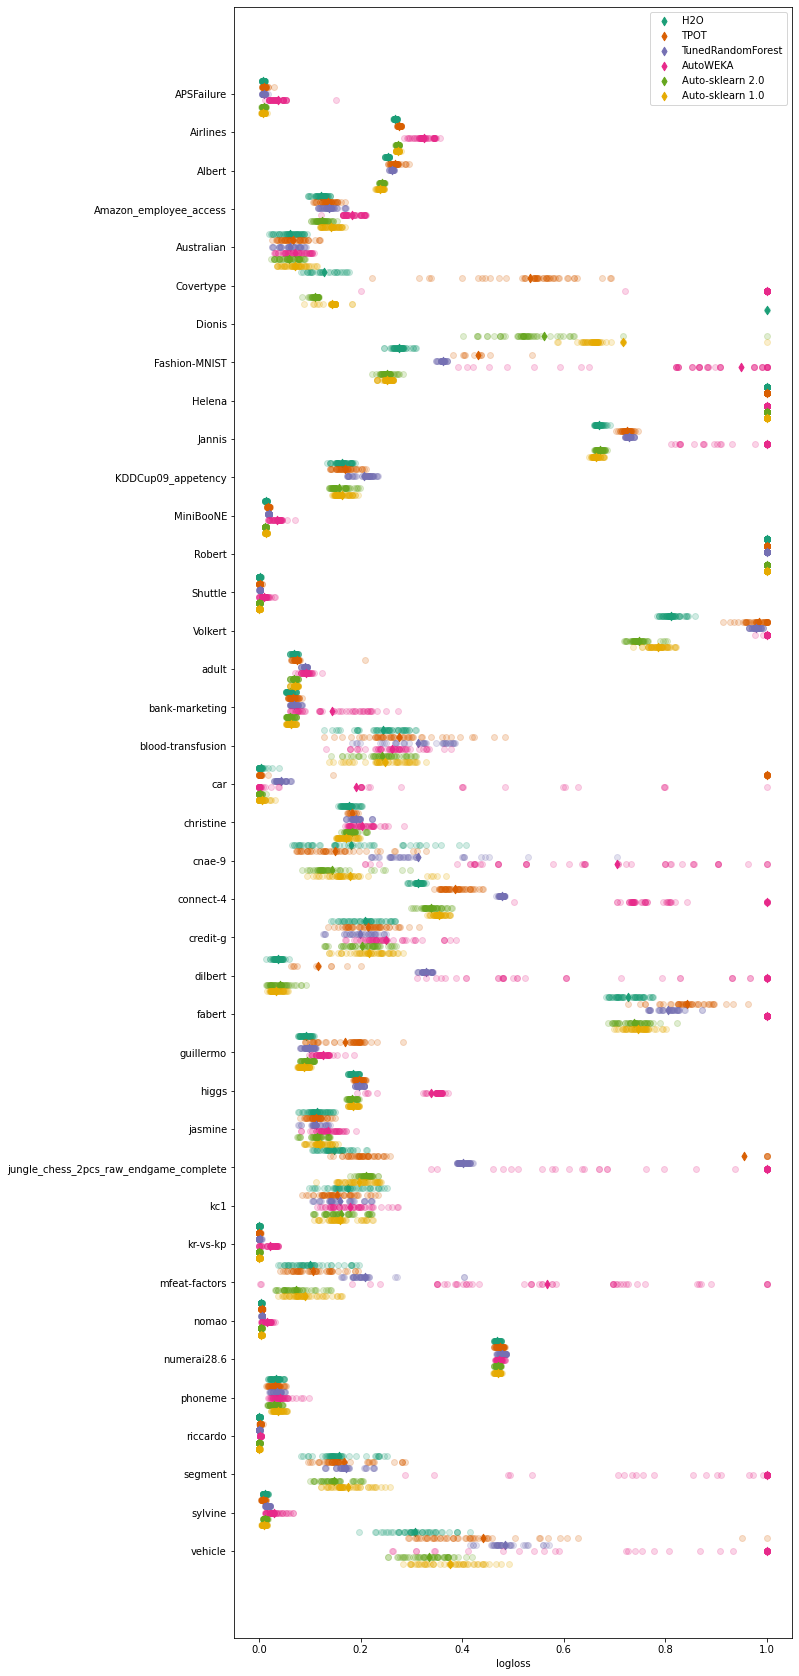

In [12]:
colors = itertools.cycle(['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666'])
    
n_comps = np.sum([len(res_average[v].keys()) for v in res_average]) + 1 # extra comp to have some spacing
ct = 0

figure = plt.figure(figsize=[10, 30])
for v in res_average.keys():
    color = next(colors)
    labelled = False
    for i, d in enumerate(datasets):
        if d not in res_average[v]: continue

        label = None
        if labelled is False:
            label = str(v)
            labelled = True
        entries = list(res_average[v][d].values())
        mean_value = np.nanmean(entries)
        
        entries = np.clip(entries, -2.5, 1)
        mean_value = np.clip(mean_value, -2.5, 1)
        
        plt.scatter(entries, [i + 1 - 1/n_comps - 1/n_comps*ct]*len(entries), c=color, alpha=0.2, marker="o")
        plt.scatter(mean_value, i + 1 - 1/n_comps - 1/n_comps*ct, c=color, marker="d", label=label)

        ct += 1

plt.yticks(np.arange(len(datasets)) + 0.5, datasets)
plt.xlabel("logloss")
plt.legend()
plt.show()

In [13]:
def make_df(res):
    df = pd.DataFrame(res)
    for idx in df.index:
        for col in df.columns:
            df.loc[idx, col] = np.nanmean(np.array(
                list(df.loc[idx, col].values())
            ).astype(float))
    print(df.columns)
    df = df[['Auto-sklearn 2.0', 'Auto-sklearn 1.0', 'AutoWEKA', 'TPOT', 'H2O', 'TunedRandomForest',]]
    return df

In [14]:
df = make_df(res_average)
df_ = df.copy()
df_.index = [idx.lower() for idx in df.index]
df_.sort_index()

Index(['H2O', 'TPOT', 'TunedRandomForest', 'AutoWEKA', 'Auto-sklearn 2.0',
       'Auto-sklearn 1.0'],
      dtype='object')


<ipython-input-13-74d193dd7146>:5: RuntimeWarning: Mean of empty slice
  df.loc[idx, col] = np.nanmean(np.array(


,Auto-sklearn 2.0,Auto-sklearn 1.0,AutoWEKA,TPOT,H2O,TunedRandomForest
adult,0.069156,0.070092,0.092039,0.075045,0.069036,0.090239
airlines,0.272443,0.272598,0.324095,0.275823,0.268174,NaN
albert,0.241305,0.238143,NaN,0.268097,0.25295,0.261624
amazon_employee_access,0.123315,0.141236,0.183567,0.134542,0.121784,0.137731
apsfailure,0.008518,0.008077,0.03651,0.009925,0.008117,0.008714
australian,0.059436,0.070207,0.070855,0.067043,0.060748,0.060993
bank-marketing,0.060668,0.061573,0.144125,0.066431,0.061006,0.069176
blood-transfusion,0.242788,0.24745,0.261938,0.276057,0.243024,0.31219
car,0.001243,0.004636,0.190967,2.784272,0.003166,0.042086
christine,0.182128,0.170254,0.202565,0.182087,0.17626,0.190799


In [15]:
df = make_df(res_average)
df.columns = ('Auto-sklearn 2.0', 'Auto-sklearn 1.0', 'AutoWEKA', 'TPOT', 'H2O', 'TunedRF')
rename = {
    'jungle_chess_2pcs_raw_endgame_complete': 'jungle_chess',
    'Amazon_employee_access': 'Amazon',
    'KDDCup09_appetency': 'KDDCup09',
}
df.index = [rename.get(name, name) for name in df.index]
df = df[['Auto-sklearn 2.0', 'Auto-sklearn 1.0', 'AutoWEKA', 'TPOT', 'H2O', 'TunedRF']]
df_ = df.copy()
df_.index = [idx.lower() for idx in df.index]
df_ = df_.sort_index()

class formatter:
    
    def __init__(self, df, column):
        self.df = df
        self.column = column
        self.idx = 0
        
    def __call__(self, value):
        self.idx += 1
        if value == 100:
            return '-'
        else:
            if self.df.iloc[(self.idx - 1) % 39].min() == value:
                return '$\mathbf{%2.4f}$' % value
            else:
                return '$%2.4f$' % value

formatters = [
    formatter(df_, column) for column in df_.columns
]

print(df_.fillna(value=100).to_latex(formatters=formatters, column_format='lrrrrrr', escape=False))

<ipython-input-13-74d193dd7146>:5: RuntimeWarning: Mean of empty slice
  df.loc[idx, col] = np.nanmean(np.array(


Index(['H2O', 'TPOT', 'TunedRandomForest', 'AutoWEKA', 'Auto-sklearn 2.0',
       'Auto-sklearn 1.0'],
      dtype='object')
\begin{tabular}{lrrrrrr}
\toprule
{} &  Auto-sklearn 2.0 &  Auto-sklearn 1.0 &  AutoWEKA &              TPOT &               H2O &           TunedRF \\
\midrule
adult             &          $0.0692$ &          $0.0701$ &  $0.0920$ &          $0.0750$ & $\mathbf{0.0690}$ &          $0.0902$ \\
airlines          &          $0.2724$ &          $0.2726$ &  $0.3241$ &          $0.2758$ & $\mathbf{0.2682}$ &                 - \\
albert            &          $0.2413$ & $\mathbf{0.2381}$ &         - &          $0.2681$ &          $0.2530$ &          $0.2616$ \\
amazon            &          $0.1233$ &          $0.1412$ &  $0.1836$ &          $0.1345$ & $\mathbf{0.1218}$ &          $0.1377$ \\
apsfailure        &          $0.0085$ & $\mathbf{0.0081}$ &  $0.0365$ &          $0.0099$ &          $0.0081$ &          $0.0087$ \\
australian        & $\mathbf{0.0594}$ &          

In [16]:
df__ = df_.copy()
df__ = df__.fillna(100)
p_values = []
for column in df__:
    if column == 'Auto-sklearn 2.0':
        p_values.append('-')
    else:
        wins = np.sum(df__['Auto-sklearn 2.0'] < df__[column])
        losses = np.sum(df__['Auto-sklearn 2.0'] > df__[column])
        ties = np.sum(df__['Auto-sklearn 2.0'] == df__[column])
        if ties % 2 == 0:
            wins += ties / 2
            losses += ties / 2
        else:
            wins += (ties - 1) / 2
            losses += (ties - 1) / 2
        p = scipy.stats.binom_test((wins, losses))
        p2 = scipy.stats.wilcoxon(df__['Auto-sklearn 2.0'], df__[column]).pvalue
        p_values.append('%0.3f' % p)
        print(column, p, p2, wins, losses)
' & '.join(p_values)

Auto-sklearn 1.0 0.009475304279476404 0.009832223793257653 28.0 11.0
AutoWEKA 3.637978807091713e-12 5.255295360476943e-08 39.0 0.0
TPOT 3.353161446284503e-07 6.765419678287829e-07 35.0 4.0
H2O 0.05325191409792752 0.06753383562798193 26.0 13.0
TunedRF 3.608874976634979e-08 3.513753663281282e-07 36.0 3.0


'- & 0.009 & 0.000 & 0.000 & 0.053 & 0.000'

In [17]:
df = make_df(res_average)
pairwise_wins = defaultdict(dict)
pairwise_wins_without_ties = defaultdict(dict)
keys = dict()
for framework_1 in df.columns:
    tmp_keys = dict()
    key = framework_1
    for framework_2 in df.columns:
        if framework_1 == framework_2:
            key = framework_1
        else:
            pass
    keys[framework_1] = key

for framework_1 in df.columns:
    for framework_2 in df.columns:
        if framework_1 != framework_2:
            wins = 0
            losses = 0
            ties = 0
            for dataset in df.index:
                if np.isnan(df.loc[dataset, framework_1]) and np.isnan(df.loc[dataset, framework_2]):
                    wins += 0.5
                    losses += 0.5
                    ties += 0.5
                elif np.isnan(df.loc[dataset, framework_1]):
                    losses += 1
                elif np.isnan(df.loc[dataset, framework_2]):
                    wins += 1
                elif df.loc[dataset, framework_1] < df.loc[dataset, framework_2]:
                    wins += 1
                elif df.loc[dataset, framework_1] > df.loc[dataset, framework_2]:
                    losses += 1
                else:
                    wins += 0.5
                    losses += 0.5
                    ties += 0.5
            pairwise_wins[keys[framework_1]][keys[framework_2]] = wins
            pairwise_wins_without_ties[keys[framework_1]][keys[framework_2]] = wins - ties
pairwise_wins_without_ties = pd.DataFrame(pairwise_wins_without_ties).transpose()
pairwise_wins_without_ties = pairwise_wins_without_ties[pairwise_wins_without_ties.index]
pairwise_wins = pd.DataFrame(pairwise_wins).transpose()
pairwise_wins = pairwise_wins[pairwise_wins.index]
pairwise_wins

Index(['H2O', 'TPOT', 'TunedRandomForest', 'AutoWEKA', 'Auto-sklearn 2.0',
       'Auto-sklearn 1.0'],
      dtype='object')


<ipython-input-13-74d193dd7146>:5: RuntimeWarning: Mean of empty slice
  df.loc[idx, col] = np.nanmean(np.array(


,Auto-sklearn 2.0,Auto-sklearn 1.0,AutoWEKA,TPOT,H2O,TunedRandomForest
Auto-sklearn 2.0,NaN,28.0,39.0,35.0,26.0,36.0
Auto-sklearn 1.0,11.0,NaN,39.0,30.0,19.0,32.0
AutoWEKA,0.0,0.0,NaN,5.5,0.0,5.5
TPOT,4.0,9.0,33.5,NaN,5.0,23.5
H2O,13.0,20.0,39.0,34.0,NaN,35.0
TunedRandomForest,3.0,7.0,33.5,15.5,4.0,NaN


In [18]:
wins_and_losses = []
for framework in ('Auto-sklearn 1.0', 'AutoWEKA', 'TPOT', 'H2O', 'TunedRandomForest'):
    w = pairwise_wins_without_ties[framework]['Auto-sklearn 2.0']
    l = pairwise_wins_without_ties['Auto-sklearn 2.0'][framework]
    t = 39 - pairwise_wins_without_ties['Auto-sklearn 2.0'][framework] - pairwise_wins_without_ties[framework]['Auto-sklearn 2.0']
    wins_and_losses.append('$%d/%d/%d$' % (w, l, t))
' & '.join(wins_and_losses)

'$28/11/0$ & $39/0/0$ & $35/4/0$ & $26/13/0$ & $36/3/0$'

In [19]:
def rank(dataframe, datasets):
    ranks = defaultdict(int)
    for dataset in datasets:
        dataset_renaming = {
            "blood-transfusion-service-center": "blood-transfusion",
            "airlines": "Airlines",
            "albert": "Albert",
            "covertype": "Covertype",
            "shuttle": "Shuttle",
            "helena": "Helena",
            "jannis": "Jannis",
            "volkert": "Volkert",
            "robert": "Robert",
            "dionis": "Dionis",
        }
        dataset = dataset_renaming.get(dataset, dataset)
        ranking = scipy.stats.rankdata(np.nan_to_num(dataframe.loc[dataset].to_numpy().astype(float), nan=100))
        for rank, version in zip(
            ranking, 
            dataframe.columns
        ):
            ranks[version] += rank
    print("Ranks on %d datasets" % len(datasets))
    for version in ranks:
        ranks[version] = ranks[version] / len(datasets)
        print(version, ranks[version], '%1.2f' % ranks[version])
    return ranks

In [20]:
df = make_df(res_average)
df = df[['Auto-sklearn 2.0', 'Auto-sklearn 1.0', 'AutoWEKA', 'TPOT', 'H2O', 'TunedRandomForest',]]
_ = rank(df, datasets)

Index(['H2O', 'TPOT', 'TunedRandomForest', 'AutoWEKA', 'Auto-sklearn 2.0',
       'Auto-sklearn 1.0'],
      dtype='object')
Ranks on 39 datasets
Auto-sklearn 2.0 1.794871794871795 1.79
Auto-sklearn 1.0 2.641025641025641 2.64
AutoWEKA 5.717948717948718 5.72
TPOT 4.076923076923077 4.08
H2O 2.3846153846153846 2.38
TunedRandomForest 4.384615384615385 4.38


<ipython-input-13-74d193dd7146>:5: RuntimeWarning: Mean of empty slice
  df.loc[idx, col] = np.nanmean(np.array(
